In [1]:
# 기본 라이브러리
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리 라이브러리
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# 모델링 라이브러리
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# 오류 방지
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('data/Train.csv')

# train_df.head()

# 파생변수 생성
train_df['Discount10'] = (train_df['Discount_offered'] > 10).astype(int)
train_df['Weight_log'] = np.log1p(train_df['Weight_in_gms'])
train_df['BlockMode'] = train_df['Warehouse_block'].astype(str) + '_' + train_df['Mode_of_Shipment'].astype(str)

# train_df.info()

In [3]:
# 수치형 변환
labelEn = LabelEncoder()
for col in ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'BlockMode']:
    train_df[col] = labelEn.fit_transform(train_df[col].astype(str))

# train_df.head()

# 모델링에 사용할 컬럼 선택
columns = ['Discount10', 'Weight_log', 'BlockMode', 'Cost_of_the_Product', 'Prior_purchases', 'Product_importance', 'Discount_offered']

X = train_df[columns]
y = train_df['Reached.on.Time_Y.N']

In [10]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# 데이터 불균형 처리
smote = SMOTE(random_state = 42)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)

# 모델링
# CatBoost, LightGBM, XGBoost 세 개 써보고 앙상블까지 다 했는데 Catboost가 가장 좋았음
cat_model = CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.05,
    depth = 6,
    eval_metric = 'AUC',
    random_seed = 42,
    verbose = 100 
)

cat_model.fit(X_train_smt, y_train_smt, eval_set = (X_test, y_test))

0:	test: 0.7000320	best: 0.7000320 (0)	total: 4.71ms	remaining: 2.35s
100:	test: 0.7415216	best: 0.7492292 (9)	total: 524ms	remaining: 2.07s
200:	test: 0.7374709	best: 0.7492292 (9)	total: 979ms	remaining: 1.46s
300:	test: 0.7354042	best: 0.7492292 (9)	total: 1.44s	remaining: 951ms
400:	test: 0.7353441	best: 0.7492292 (9)	total: 1.89s	remaining: 466ms
499:	test: 0.7357378	best: 0.7492292 (9)	total: 2.37s	remaining: 0us

bestTest = 0.749229155
bestIteration = 9

Shrink model to first 10 iterations.


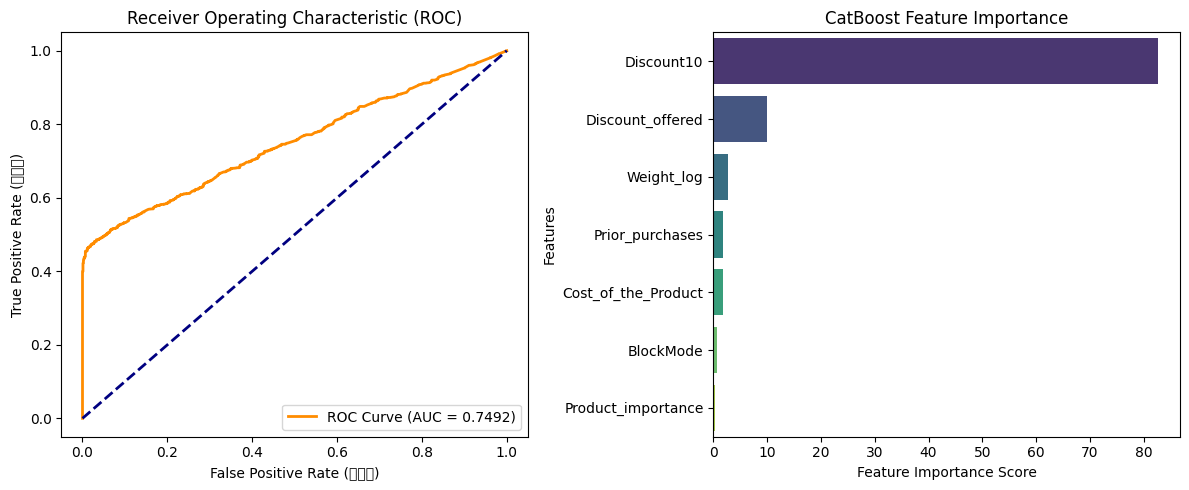

In [5]:
# 1. ROC 커브 시각화 (모델의 변별력 확인)
y_probs = cat_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(12, 5))

# 첫 번째 그래프: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (실수율)')
plt.ylabel('True Positive Rate (재현율)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 2. 변수 중요도 시각화 (어떤 변수가 지연에 큰 영향을 줬나?)
plt.subplot(1, 2, 2)
# CatBoost에서 중요도 가져오기
importances = cat_model.get_feature_importance()
feature_names = X_train.columns
feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')

plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1. 모델 예측 (이미 모델 학습이 완료된 상태여야 합니다)
y_pred = cat_model.predict(X_test)      # 0 또는 1로 예측
y_probs = cat_model.predict_proba(X_test)[:, 1] # 확률값으로 예측

# 2. 결과 출력
print("--- [모델 성능 평가 보고서] ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_probs):.4f}")
print("\n[상세 분류 보고서]")
print(classification_report(y_test, y_pred))

--- [모델 성능 평가 보고서] ---
Accuracy : 0.6714
ROC-AUC  : 0.7492

[상세 분류 보고서]
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       887
           1       0.99      0.46      0.62      1313

    accuracy                           0.67      2200
   macro avg       0.77      0.72      0.67      2200
weighted avg       0.81      0.67      0.66      2200

